In [1]:
import sys
import numpy as np
import pandas as pd
import os
import re
import xarray as xr
import pickle
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib import font_manager
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from adjustText import adjust_text
from tqdm import tqdm

sys.path.append('C:/Users/Phong/GIWAXS_Tools/')

from GIWAXSDataProcessor import GIWAXSDataProcessor
from CrystalIndexingAnalyzer import CrystalIndexingAnalyzer

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
font_dirs = ['C:/Users/Phong/Box/Research/Mixed Conduction Project/RSOXS Projects/Shared RSoXS Folder/Fonts']

font_files = font_manager.findSystemFonts(fontpaths = font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# font_names = [f.name for f in font_manager.fontManager.ttflist]
# print(font_names)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 2

In [3]:
processor = GIWAXSDataProcessor(q_max=2.0)
qzqxy, chiq, corrected_chiq = processor.process_giwaxs_file(r'C:\Users\Phong\Box\Research\Mixed Conduction Project\RSOXS Projects\Shared RSoXS Folder\GIWAXS\Neutral_Blends\EPEN\EPEN_0p1deg_120s_08241133_0001_qzqxy.tif')

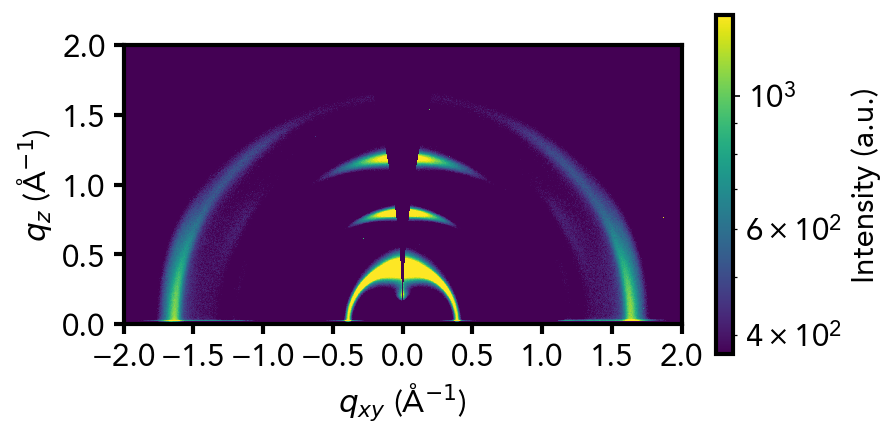

In [4]:
fig, ax = processor.plot_qzqxy(qzqxy, qxy_limits=(-2, 2), qz_limits=(0, 2), cmap='viridis')
plt.show()

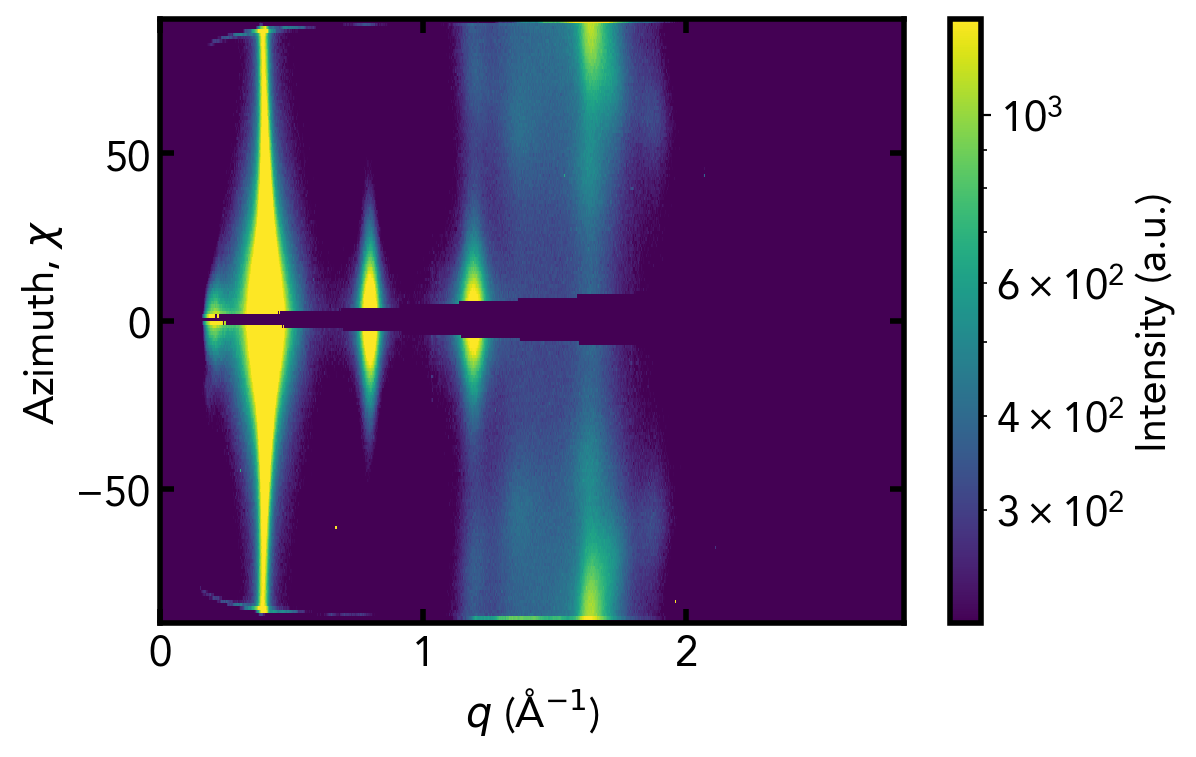

In [5]:
fig, ax = processor.plot_chiq(chiq, cmap='viridis')
plt.show()

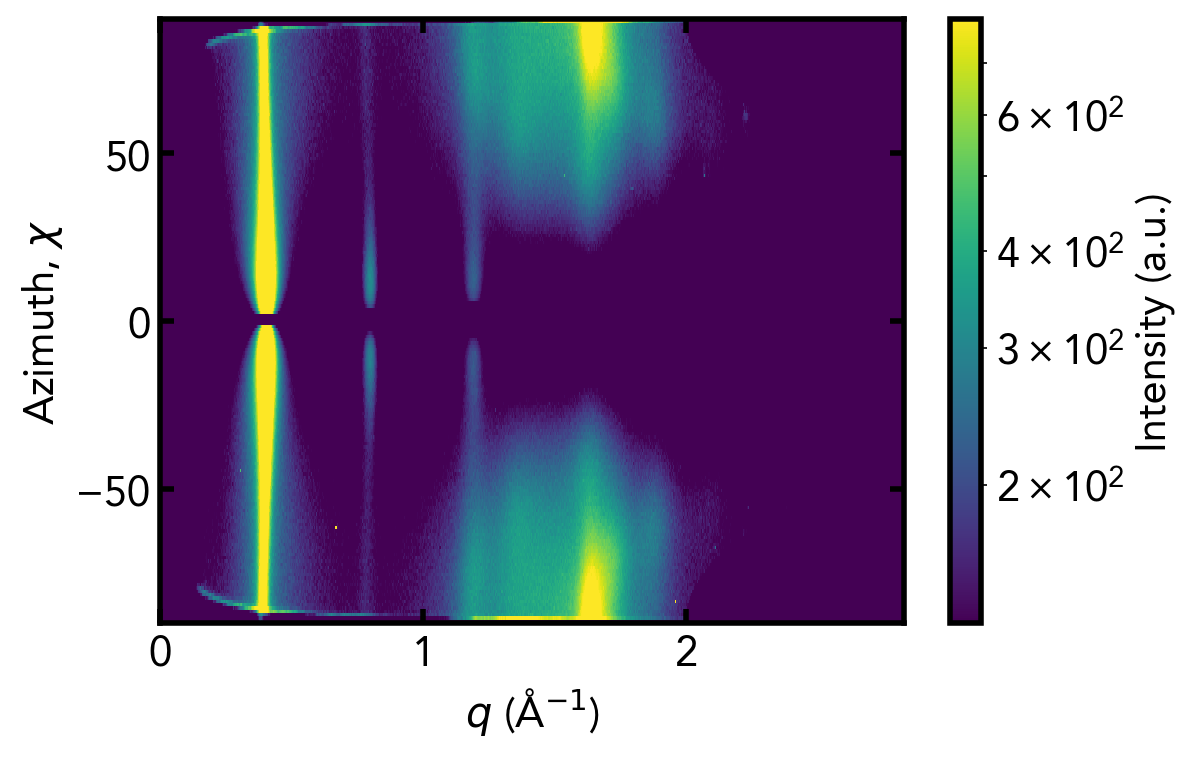

In [6]:
fig, ax = processor.plot_chiq(corrected_chiq, cmap='viridis')
plt.show()

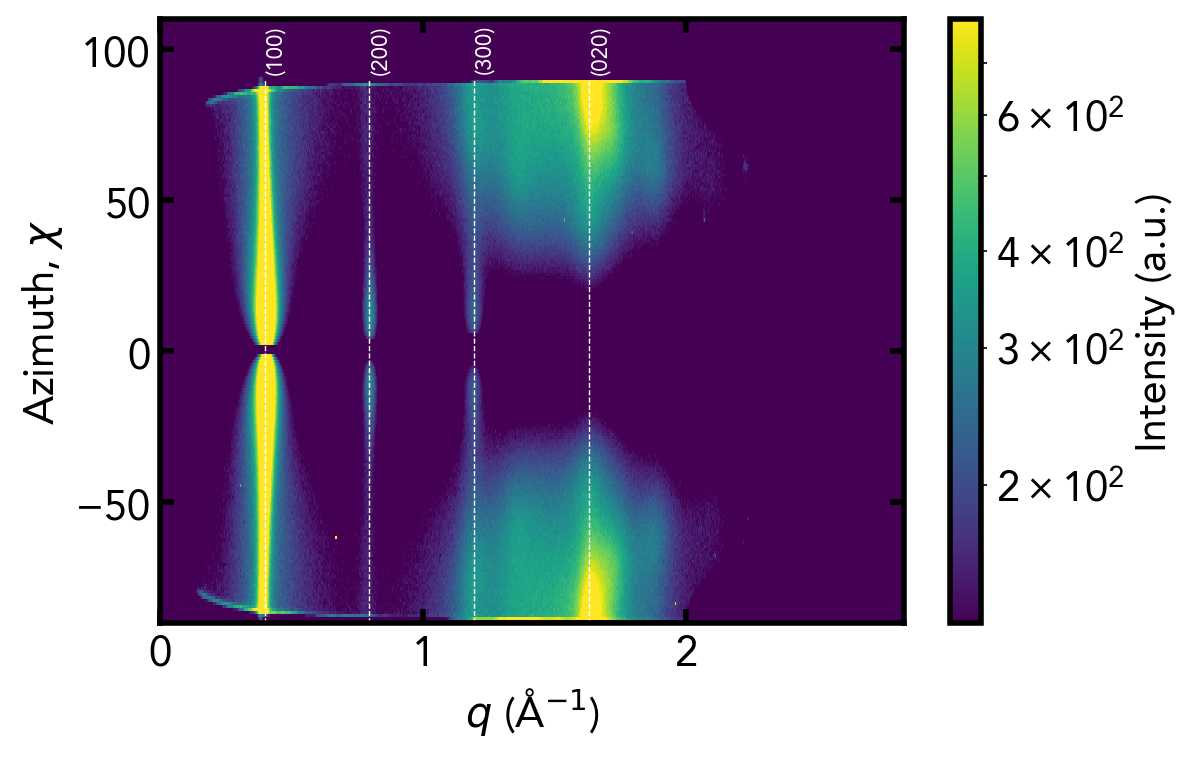

In [7]:
# Set display options for pandas DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Initialize custom Miller indices and other parameters
custom_miller_indices = [(1, 0, 0), (2, 0, 0), (3, 0, 0), (0, 2, 0)]
# custom_miller_indices = []
max_miller_index = 3
space_group = 'monoclinic'
a = 15.8
b = 7.7
c = 7.6
alpha = 90
beta = 90
gamma = 87

# Create an object of CrystalIndexingAnalyzer
analyzer = CrystalIndexingAnalyzer(space_group, a, b, c, alpha, beta, gamma)

# Call the compute_spacing method
spacing_table = analyzer.compute_spacing(custom_miller_indices, max_miller_index)

# Sort the DataFrame by QSpace_AngstromInverse in ascending order
spacing_table = spacing_table.sort_values(by='QSpace_AngstromInverse')
                         
fig, ax = processor.plot_chiq(corrected_chiq, cmap='viridis')

ax.set_ylim([-90, 110])  # change upper y-axis limit

# Get the maximum q value from the chiq DataFrame
max_q = corrected_chiq['q'].max()

texts = []
# Iterate over DataFrame rows
for idx, row in spacing_table.iterrows():
    # Get q value and Miller indices
    q = row['QSpace_AngstromInverse']
    h, k, l = row['h'], row['k'], row['l']
    
    # If q is greater than max_q, break the loop
    if q > max_q:
        break
    
    # Check if all Miller indices are non-negative
    if all(index >= 0 for index in [h, k, l]):
        # Add vertical line at q
        ax.plot([q, q], [-90, 90], color='white', linestyle='--', linewidth=0.5)  # line span from -90 to +90

        # Create label with plus-minus sign before non-zero Miller indices
        miller_indices_label = f'({int(abs(h))}{int(abs(k))}{int(abs(l))})'  # Concatenate the indices without commas

        # Add label with Miller indices
        texts.append(ax.text(q, 93.5, miller_indices_label, rotation=90, fontsize=8, color='white'))  # change color to white

# Adjust the position of text labels
adjust_text(texts, expand_text=(1.05, 1.2), expand_points=(1.05, 1.2), force_text=(0.75, 0.75), force_points=(0.75, 0.75))

# Show the plot
plt.show()

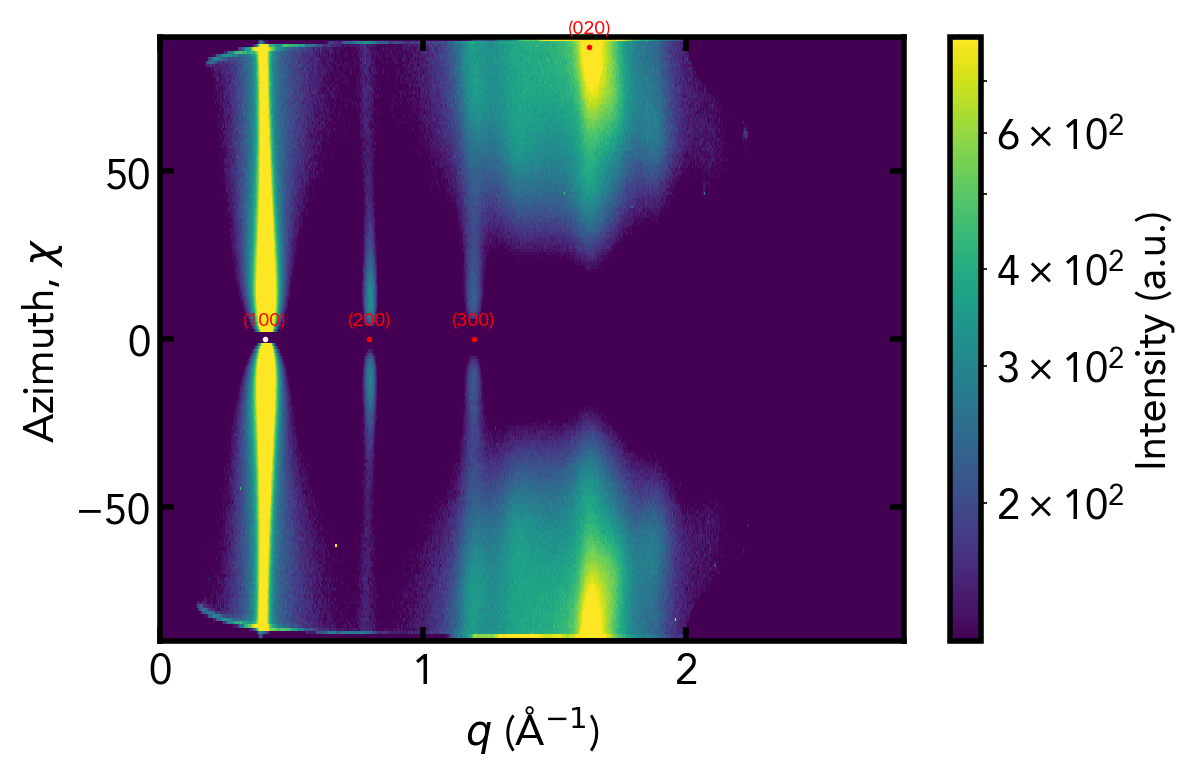

In [8]:
# User specified Miller indices (h1, k1, l1) and approximate chi value
h1, k1, l1 = 1, 0, 0 
approx_chi = 0

# Calculate 'Interplanar Angle' and 'Chi'
spacing_table = analyzer.calculate_interplanar_and_chi(spacing_table, h1, k1, l1, approx_chi = approx_chi)

# Generate the chi-q plot
fig, ax = processor.plot_chiq(corrected_chiq, cmap='viridis')

# Plot a circle at the chi and q of the user-specified Miller index
ref_q = spacing_table.loc[(spacing_table['h'] == h1) & (spacing_table['k'] == k1) & (spacing_table['l'] == l1), 'QSpace_AngstromInverse'].values[0]
ax.plot(ref_q, approx_chi, marker='.', markersize=2, color='white')

# Create a list to collect all the text objects for adjusting
texts = []

# Iterate through the rest of the list and plot the interplanar angles
for idx, row in spacing_table.iterrows():
    q = row['QSpace_AngstromInverse']
    chi = row['Chi']

    # If the current point is the reference point, skip it
    if row['h'] == h1 and row['k'] == k1 and row['l'] == l1:
        text = ax.annotate(f'({abs(int(h1))}{abs(int(k1))}{abs(int(l1))})', (ref_q, approx_chi), textcoords="offset points", xytext=(0,5), ha='center', color='red', fontsize=7)
        texts.append(text)
        continue

    # Plot a small dot for each other Miller index within the range of -90 to 90
    if -90 <= chi <= 90:
        ax.plot(q, chi, marker='.', markersize=2, color='red')
        text = ax.annotate(f'({abs(int(row["h"]))}{abs(int(row["k"]))}{abs(int(row["l"]))})', (q, chi), textcoords="offset points", xytext=(0,5), ha='center', color='red', fontsize=7)
        texts.append(text)

# Adjust the texts to minimize overlaps
# adjust_text(texts)

# Show the plot
plt.show()

In [9]:
spacing_table

h  k  l  RealSpace_Angstroms  QSpace_AngstromInverse  Interplanar Angle  \
0  1  0  0            15.800000                0.397670                0.0   
4 -1  0  0            15.800000                0.397670             -180.0   
1  2  0  0             7.900000                0.795340                0.0   
5 -2  0  0             7.900000                0.795340             -180.0   
2  3  0  0             5.266667                1.193010                0.0   
6 -3  0  0             5.266667                1.193010             -180.0   
3  0  2  0             3.850000                1.631996               87.0   
7  0 -2  0             3.850000                1.631996              -93.0   

     Chi  
0    0.0  
4 -180.0  
1    0.0  
5 -180.0  
2    0.0  
6 -180.0  
3   87.0  
7  -93.0

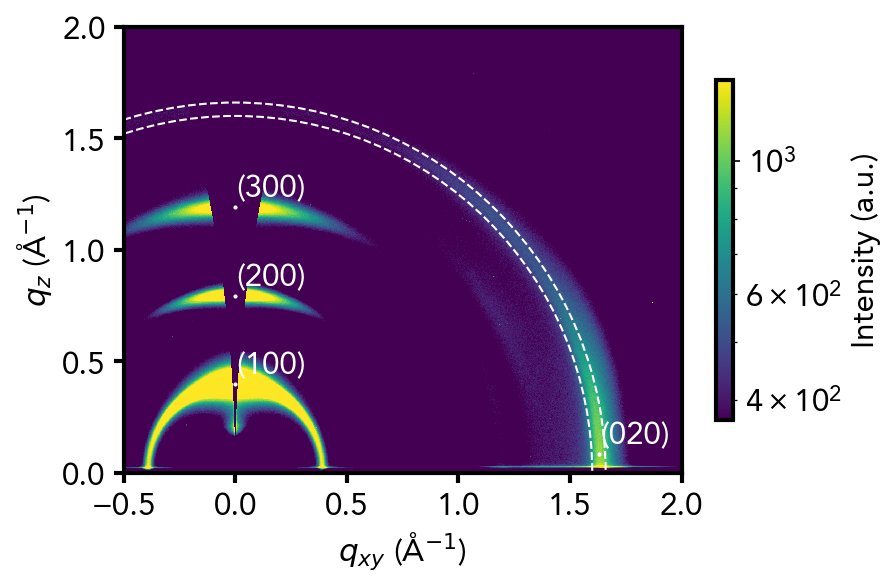

In [10]:
qxy_lower, qxy_upper = -0.5, 2 
qz_lower, qz_upper = 0, 2  

fig, ax = processor.plot_qzqxy(qzqxy, qxy_limits=(qxy_lower, qxy_upper), qz_limits=(qz_lower, qz_upper), cmap='viridis')


# Add dashed circles
circle_lower = Circle((0, 0), 1.6, color='white', fill=False, linestyle='dashed', linewidth=1)
circle_upper = Circle((0, 0), 1.66, color='white', fill=False, linestyle='dashed', linewidth=1)

ax.add_artist(circle_lower)
ax.add_artist(circle_upper)

spacing_table = analyzer.compute_q_coordinates(spacing_table)

# Add your texts to a list instead of the plot
texts = []

# Plot a circle at the qxy and qz of the user-specified Miller index
ref_qxy = spacing_table.loc[(spacing_table['h'] == h1) & (spacing_table['k'] == k1) & (spacing_table['l'] == l1), 'qxy'].values[0]
ref_qz = spacing_table.loc[(spacing_table['h'] == h1) & (spacing_table['k'] == k1) & (spacing_table['l'] == l1), 'qz'].values[0]
ax.plot(ref_qxy, ref_qz, marker='.', markersize=2, color='white')
texts.append(ax.text(ref_qxy, ref_qz, f'({int(h1)}{int(k1)}{int(l1)})', ha='center', va='center', fontsize=15, color='white'))

for idx, row in spacing_table.iterrows():
    qxy = row['qxy']
    qz = row['qz']

    # Only plot points and labels if they're within the user-specified axis limits
    if qxy >= qxy_lower and qxy <= qxy_upper and qz >= qz_lower and qz <= qz_upper:
        # Skip the reference point
        if row['h'] == h1 and row['k'] == k1 and row['l'] == l1:
            continue
        ax.plot(qxy, qz, marker='.', markersize=2, color='white')
        texts.append(ax.text(qxy, qz, f'({abs(int(row["h"]))}{abs(int(row["k"]))}{abs(int(row["l"]))})', ha='center', va='center', fontsize=15, color='white'))

# Use adjust_text, which will take care of text overlapping
# adjust_text will stop after 500 iterations (default) or when no overlap will be detected
adjust_text(texts)

# Show the plot
plt.show()

fig.savefig('P3HT_GIWAXS_Example.tiff', bbox_inches = 'tight', pad_inches = 0.2, dpi = 300, transparent = False)

In [11]:
spacing_table

h  k  l  RealSpace_Angstroms  QSpace_AngstromInverse  Interplanar Angle  \
0  1  0  0            15.800000                0.397670                0.0   
1  2  0  0             7.900000                0.795340                0.0   
2  3  0  0             5.266667                1.193010                0.0   
3  0  2  0             3.850000                1.631996               87.0   
4  0 -2  0             3.850000                1.631996              -93.0   

    Chi      qxy        qz  
0   0.0  0.00000  0.397670  
1   0.0  0.00000  0.795340  
2   0.0  0.00000  1.193010  
3  87.0  1.62976  0.085412  
4 -93.0 -1.62976 -0.085412

In [25]:
with open('giwaxs_results.pkl', 'rb') as file:
    data = pickle.load(file)

sample_names = data[0]
incidence_angles = data[1]
exposure_times = data[2]
filenames = data[3]
qzqxys = data[4]
chiqs = data[5]
corrected_chiqs = data[6]
background_subtracted_qzqxys = data[7]
background_subtracted_chiqs = data[8]
background_subtracted_corrected_chiqs = data[9]
q_lowers = data[10]
q_uppers = data[11]

In [26]:
# Initialize the list to hold `None` for all samples
orientation_dists = [None] * len(background_subtracted_corrected_chiqs)

In [27]:
for iteration, (q_upper, q_lower) in enumerate(zip(q_uppers, q_lowers)):
    
    # Clear output after iteration
    clear_output(wait=True)

    try:
        print(f"Iteration {iteration}, q_lower: {q_lower}, q_upper: {q_upper}")

#         fig, ax = processor.plot_qzqxy_sq(background_subtracted_qzqxys[iteration])

#         # Add dashed circles
#         circle_lower = Circle((0, 0), q_lower, color='white', fill=False, linestyle='dashed', linewidth=1)
#         circle_upper = Circle((0, 0), q_upper, color='white', fill=False, linestyle='dashed', linewidth=1)

#         ax.add_artist(circle_lower)
#         ax.add_artist(circle_upper)

#         plt.show()

    except ValueError as e:
        if 'Invalid vmin or vmax' in str(e):
            print(f"Skipping plot for xarray at iteration {iteration}: xarray is empty.")
            continue
        else:
            print(f"An unexpected error occurred: {e}")

    negative_chi = background_subtracted_corrected_chiqs[iteration].sel(q=slice(q_lower,q_upper), chi=slice(-88,0)).mean('q')
    negative_chi['chi'] = abs(negative_chi['chi'])
    positive_chi = background_subtracted_corrected_chiqs[iteration].sel(q=slice(q_lower,q_upper), chi=slice(0,88)).mean('q')

    chi_common = np.linspace(0, 90, num=1000)
    negative_chi = negative_chi.interp(chi=chi_common)
    positive_chi = negative_chi.interp(chi=chi_common)

    # averaging the two datasets
    average_chi = 0.5 * (negative_chi + positive_chi)
    # average_chi = 0.5 * (negative_chi)

    # Normalize the data so it sums to 1
    normalized_chi = average_chi / average_chi.sum()

    # Convert to percentage
    percentage_chi = normalized_chi * 100

    percentage_chi.attrs.update({
        'q_lower': q_lower,
        'q_upper': q_upper
    })

#     # Create a histogram plot
#     fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=150)
#     ax.hist(percentage_chi['chi'], weights=percentage_chi, bins=20, edgecolor='black')
#     ax.set_xlabel('Azimuth, $\\it{χ}$')
#     ax.set_ylabel('Percentage (%)')
#     plt.tight_layout()
#     plt.show()

    # Store the percentage_chi in orientation_dists dictionary
    orientation_dists[iteration] = percentage_chi

data.append(orientation_dists)

Iteration 48, q_lower: 1.62, q_upper: 1.69


In [28]:
def generate_ticks(start, end, num_ticks, rounding_order):
    tick_spacing = (end - start) / (num_ticks - 1)
    tick_vals = [start + i * tick_spacing for i in range(num_ticks)]
    rounded_tick_vals = [round(val / rounding_order) * rounding_order for val in tick_vals]
    
    return rounded_tick_vals

def filter_data(data, current_samples, current_incidence_angle, key):
    ## filter the larger pool of data to contain only data pertaining to the selected edge:
    # create boolean list to filter larger pool of data
    samples = data[0]
    incidence_angles = data[1]

    filter_list = []
    del filter_list
    filter_list = []

    for i, (sample, incidence_angle) in enumerate(zip(samples, incidence_angles)):
        if (sample in current_samples) and (incidence_angle == current_incidence_angle):
            filter_list.append(True)
        else:
            filter_list.append(False)

    # use boolean list to filter data
    filtered_data = []
    del filtered_data
    filtered_data = []

    for i, list_item in enumerate(data):
        filtered_list = []
        del filtered_list
        filtered_list = []
        for j, item in enumerate(data[i]):
            if filter_list[j]:
                filtered_list.append(item)
        filtered_data.append(filtered_list)
        
    # create dict of lists for ease with selecting data to make into mosaic
    data_dict = {'sample_names':filtered_data[0], 
                 'incidence_angles': filtered_data[1], 
                 'exposure_times': filtered_data[2], 
                 'filenames': filtered_data[3], 
                 'qzqxys': filtered_data[4], 
                 'chiqs': filtered_data[5], 
                 'corrected_chiqs': filtered_data[6], 
                 'background_subtracted_qzqxys': filtered_data[7],
                 'background_subtracted_chiqs': filtered_data[8],
                 'background_subtracted_corrected_chiqs': filtered_data[9],
                 'q_lowers': filtered_data[10],
                 'q_uppers': filtered_data[11],
                 'orientation_dists': filtered_data[12]}

    dicts = dict(zip(data_dict['sample_names'], data_dict[key]))

    scales = []
#     for key in data_dict['sample_names']:
#         scales.append(np.nanmax([abs(np.nanpercentile(dicts[key],1)), abs(np.nanpercentile(dicts[key],99))]))
    
    return dicts, scales

In [29]:
def plot_qzqxy_grid(dicts, dicts_q_lower, dicts_q_upper, scales, current_samples, start_q, end_q, q_rounding_order):
    fig, axes = plt.subplots(3, 5, figsize=(3.5*5, 3.5*3))
    
    x_ticks = generate_ticks(start_q, end_q, num_ticks = 5, rounding_order = q_rounding_order)
    y_ticks = generate_ticks(start_q, end_q, num_ticks = 5, rounding_order = q_rounding_order)

    for j in range(3):
        for i in range(5):
            key = current_samples[i*3+j]
            ax = axes[j, i]

            if key in dicts:
                qzqxy = dicts[key].sel(qxy=slice(start_q, end_q),qz=slice(start_q, end_q))
                
                # Mirror and sum the data
                mirrored_qzqxy = qzqxy.sel(qxy=slice(None, 0))
                mirrored_qzqxy['qxy'] = -mirrored_qzqxy['qxy']
                truncated_qzqxy = qzqxy.sel(qxy=slice(0, 2))
                combined_qzqxy = truncated_qzqxy + mirrored_qzqxy.reindex_like(truncated_qzqxy, method='nearest', tolerance=1e-5).fillna(0)
                
                # Plot
                im = combined_qzqxy.plot(x='qxy', y='qz', ax=ax, norm=LogNorm(np.nanpercentile(combined_qzqxy, 10), np.nanpercentile(combined_qzqxy, 99)),
                                         cmap='viridis', add_colorbar=False)
                
                # Add dashed circles to represent fixed q values
                circle_lower = Circle((0, 0), dicts_q_lowers[key], color='white', fill=False, linestyle='dashed', linewidth=1)
                circle_upper = Circle((0, 0), dicts_q_uppers[key], color='white', fill=False, linestyle='dashed', linewidth=1)

                ax.add_artist(circle_lower)
                ax.add_artist(circle_upper)
                
            else:
                ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', fontsize=18)

            ax.text(0.7, 0.875, key, color='black', fontsize=18,
                    transform=ax.transAxes, horizontalalignment='left',
                    bbox=dict(facecolor='white', edgecolor='white', alpha=0.75))

            ax.set_xticklabels('')
            ax.set_yticklabels('')
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticks(x_ticks)
            ax.set_yticks(y_ticks)
            ax.set_xlim([start_q, end_q])
            ax.set_ylim([start_q, end_q])
            ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='inout', top='on')
            ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='inout', right='on')
    
   # format title and labels
    top_labels = ['20/5/75\n(5 kDa/23 kDa/RRa)',
                  '40/5/55\n(5 kDa/23 kDa/RRa)', '50/5/45\n(5 kDa/23 kDa/RRa)',
                  '70/0/30\n(5 kDa/23 kDa/RRa)', '100/0/0\n(5 kDa/23 kDa/RRa)']
    for i, label in enumerate(top_labels):
        ax = axes[0, i]
        ax.text(0.5, 1.2, label, color='black', fontsize=20, transform=ax.transAxes,
                horizontalalignment='center', verticalalignment='center')
        ax = axes[-1, i]
        ax.set_xlabel('$\it{q_{xy}}$ (Å$^{-1}$)', fontsize=20)
        x_ticks_strs = [str(value) for value in x_ticks]
        x_ticks_strs[0] = ''
        x_ticks_strs[-1] = ''
        ax.set_xticklabels(x_ticks_strs)
        # Setting fontsize for x-axis tick labels
        ax.set_xticklabels(x_ticks_strs, fontsize=20)

    for i, label in enumerate(['Undoped', 'F$_{4}$TCNQ$^{•-}$ \n vapor', 'TFSI$^{-}$ anion \n exhanged']):
        ax = axes[i, 0]
        ax.set_ylabel('$\it{q_{z}}$ (Å$^{-1}$)', fontsize=20)
        y_ticks_strs = [str(value) for value in y_ticks]
        y_ticks_strs[0] = ''
        y_ticks_strs[-1] = ''
        ax.set_yticklabels(y_ticks_strs)
        # Setting fontsize for y-axis tick labels
        ax.set_yticklabels(y_ticks_strs, fontsize=20)
        ax.text(-1, 0.5, label, color='black', fontsize=20, transform=ax.transAxes,
                horizontalalignment='left', verticalalignment='center')

    plt.tight_layout()

#     # format colorbar
#     cbar_ax = fig.add_axes([1, 0.11, 0.01, 0.725])
#     cbar = fig.colorbar(im, cax=cbar_ax, format=FuncFormatter(fmt_AR))
#     cbar.ax.set_ylabel('Intensity')
    plt.show()

    return fig, axes

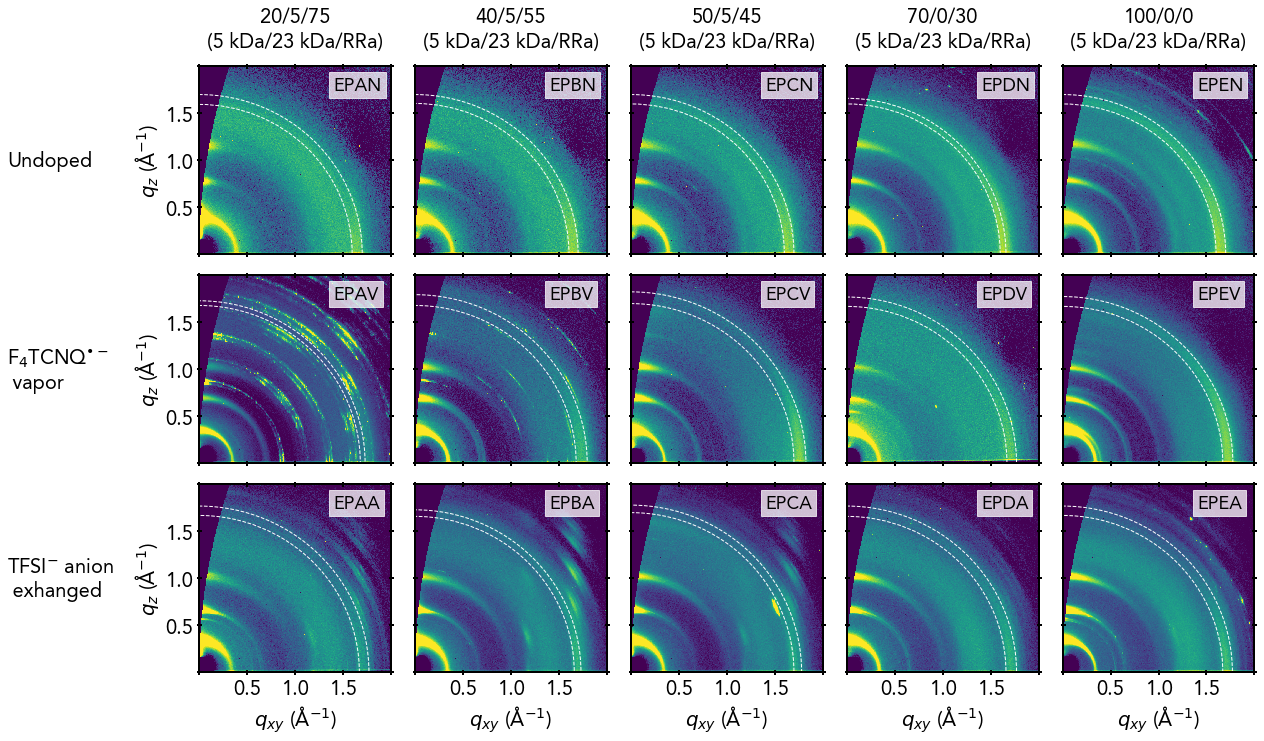

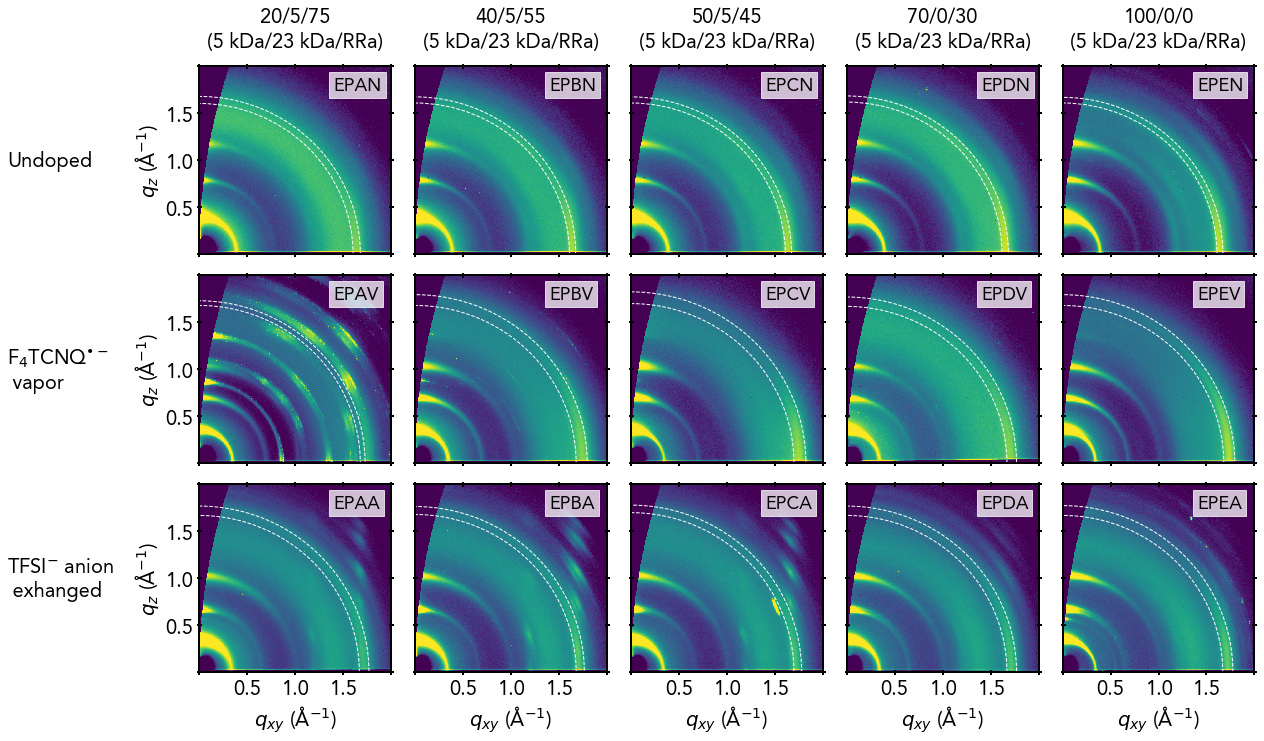

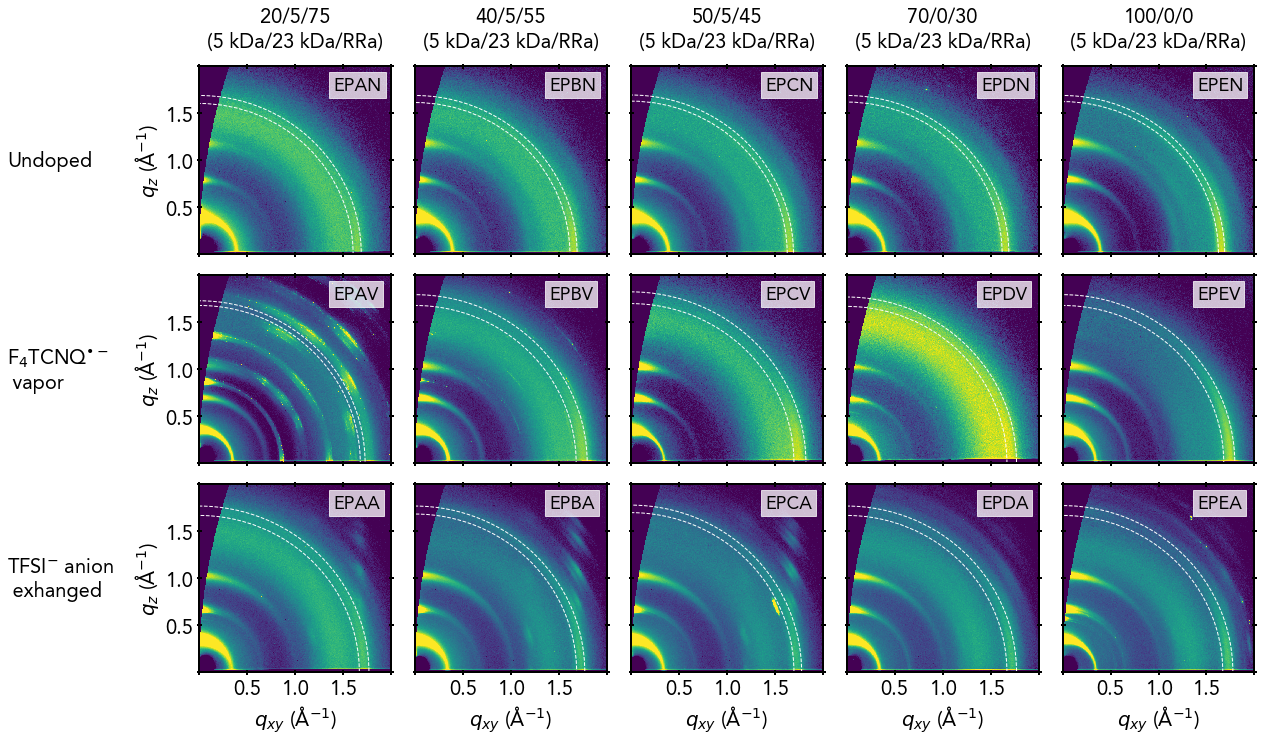

In [17]:
current_incidence_angle = 0.05

current_samples = ['EPAN', 'EPAV', 'EPAA', 'EPBN', 'EPBV', 'EPBA', 'EPCN', 'EPCV', 'EPCA', 'EPDN', 'EPDV', 'EPDA', 'EPEN', 'EPEV', 'EPEA']

dicts, scales = filter_data(data, current_samples, current_incidence_angle, 'background_subtracted_qzqxys')

dicts_q_lowers, scales = filter_data(data, current_samples, current_incidence_angle, 'q_lowers')

dicts_q_uppers, scales = filter_data(data, current_samples, current_incidence_angle, 'q_uppers')

[fig, axes] = plot_qzqxy_grid(dicts, dicts_q_lowers, dicts_q_uppers, scales, current_samples, 0, 2, 0.5)

fig.savefig('giwaxs_grid_0p05.tiff', bbox_inches = 'tight', pad_inches = 0.2, dpi = 300, transparent = False)


current_incidence_angle = 0.1

current_samples = ['EPAN', 'EPAV', 'EPAA', 'EPBN', 'EPBV', 'EPBA', 'EPCN', 'EPCV', 'EPCA', 'EPDN', 'EPDV', 'EPDA', 'EPEN', 'EPEV', 'EPEA']

dicts, scales = filter_data(data, current_samples, current_incidence_angle, 'background_subtracted_qzqxys')

dicts_q_lowers, scales = filter_data(data, current_samples, current_incidence_angle, 'q_lowers')

dicts_q_uppers, scales = filter_data(data, current_samples, current_incidence_angle, 'q_uppers')

[fig, axes] = plot_qzqxy_grid(dicts, dicts_q_lowers, dicts_q_uppers, scales, current_samples, 0, 2, 0.5)

fig.savefig('giwaxs_grid_0p1.tiff', bbox_inches = 'tight', pad_inches = 0.2, dpi = 300, transparent = False)


current_incidence_angle = 0.13

current_samples = ['EPAN', 'EPAV', 'EPAA', 'EPBN', 'EPBV', 'EPBA', 'EPCN', 'EPCV', 'EPCA', 'EPDN', 'EPDV', 'EPDA', 'EPEN', 'EPEV', 'EPEA']

dicts, scales = filter_data(data, current_samples, current_incidence_angle, 'background_subtracted_qzqxys')

dicts_q_lowers, scales = filter_data(data, current_samples, current_incidence_angle, 'q_lowers')

dicts_q_uppers, scales = filter_data(data, current_samples, current_incidence_angle, 'q_uppers')

[fig, axes] = plot_qzqxy_grid(dicts, dicts_q_lowers, dicts_q_uppers, scales, current_samples, 0, 2, 0.5)

fig.savefig('giwaxs_grid_0p13.tiff', bbox_inches = 'tight', pad_inches = 0.2, dpi = 300, transparent = False)

In [18]:
def plot_orientation_hists_grid(dicts, current_samples):
    fig, axes = plt.subplots(3, 5, figsize=(3.5*5, 3.5*3))
    
    x_ticks = generate_ticks(0, 90, num_ticks = 4, rounding_order = 1)
    y_ticks = generate_ticks(0, 16, num_ticks = 5, rounding_order = 1)

    for j in range(3):
        for i in range(5):
            key = current_samples[i*3+j]
            ax = axes[j, i]

            if key in dicts:
                ax.hist(dicts[key]['chi'], weights=dicts[key], bins=20, edgecolor='black')
                
            else:
                ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', fontsize=18)

#             ax.text(0.035, 0.875, key, color='black', fontsize=18,
#                     transform=ax.transAxes, horizontalalignment='left',
#                     bbox=dict(facecolor='white', edgecolor='white', alpha=0.75))

            ax.set_xticklabels('')
            ax.set_yticklabels('')
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticks(x_ticks)
            ax.set_yticks(y_ticks)
            ax.set_xlim([0, 90])
            ax.set_ylim([0, 15])
            ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='inout', top='on')
            ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='inout', right='on')
    
   # format title and labels
    top_labels = ['20/5/75\n(5 kDa/23 kDa/RRa)',
                  '40/5/55\n(5 kDa/23 kDa/RRa)', '50/5/45\n(5 kDa/23 kDa/RRa)',
                  '70/0/30\n(5 kDa/23 kDa/RRa)', '100/0/0\n(5 kDa/23 kDa/RRa)']
    for i, label in enumerate(top_labels):
        ax = axes[0, i]
        ax.text(0.5, 1.2, label, color='black', fontsize=20, transform=ax.transAxes,
                horizontalalignment='center', verticalalignment='center')
        ax = axes[-1, i]
        ax.set_xlabel('Azimuth, $\it{χ}$', fontsize=20)
        x_ticks_strs = [str(value) + '°' for value in x_ticks]  # Adding degree symbol
        x_ticks_strs[0] = ''
        x_ticks_strs[-1] = ''
        ax.set_xticklabels(x_ticks_strs)
        # Setting fontsize for x-axis tick labels
        ax.set_xticklabels(x_ticks_strs, fontsize=20)

    for i, label in enumerate(['Undoped', 'F$_{4}$TCNQ$^{•-}$ \n vapor', 'TFSI$^{-}$ anion \n exhanged']):
        ax = axes[i, 0]
        ax.set_ylabel('Percentage (%)', fontsize=20)
        y_ticks_strs = [str(value) for value in y_ticks]
        y_ticks_strs[0] = ''
        y_ticks_strs[-1] = ''
        ax.set_yticklabels(y_ticks_strs)
        # Setting fontsize for y-axis tick labels
        ax.set_yticklabels(y_ticks_strs, fontsize=20)
        ax.text(-1, 0.5, label, color='black', fontsize=20, transform=ax.transAxes,
                horizontalalignment='left', verticalalignment='center')

    plt.tight_layout()

#     # format colorbar
#     cbar_ax = fig.add_axes([1, 0.11, 0.01, 0.725])
#     cbar = fig.colorbar(im, cax=cbar_ax, format=FuncFormatter(fmt_AR))
#     cbar.ax.set_ylabel('Intensity')
    plt.show()

    return fig, axes

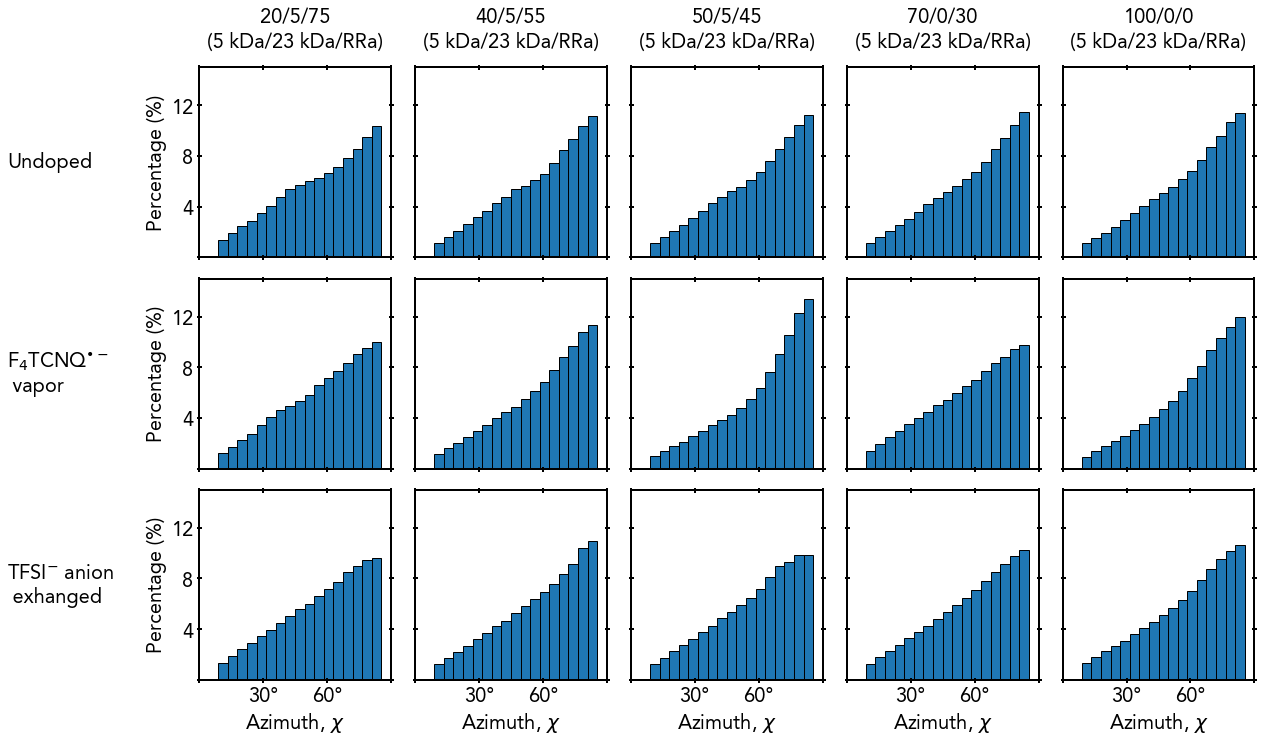

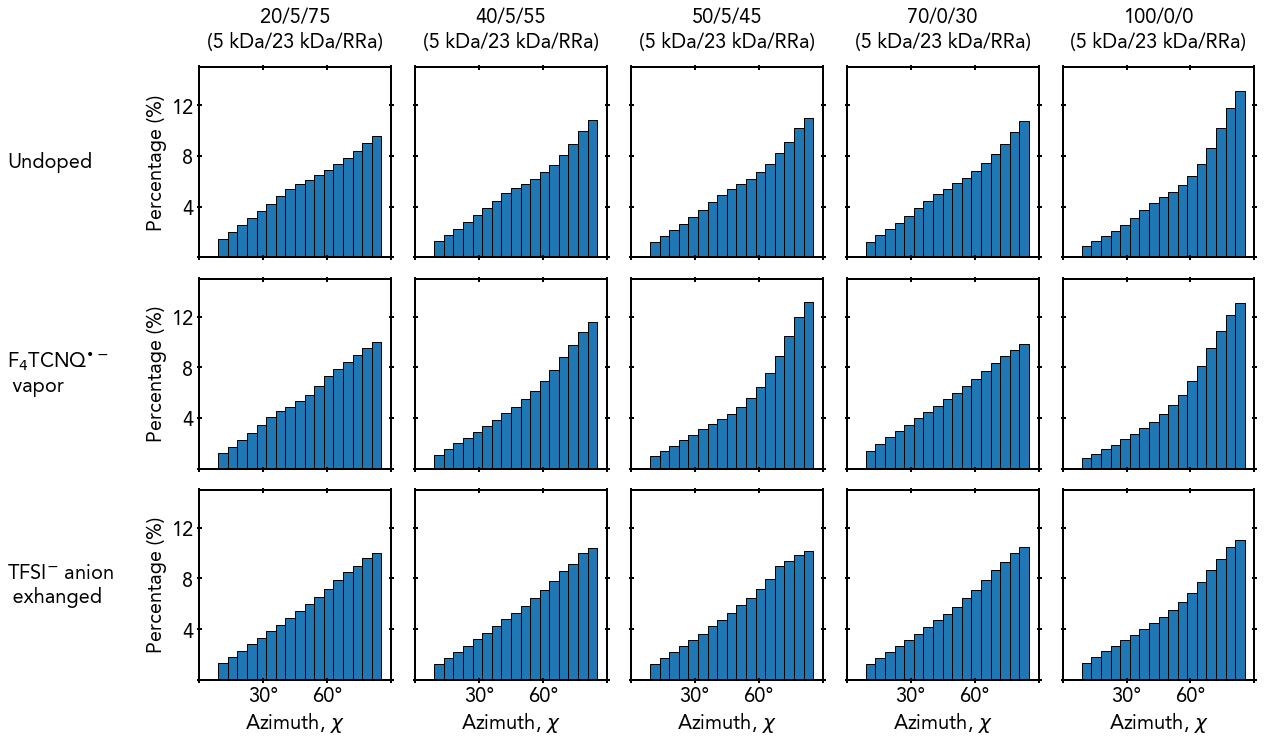

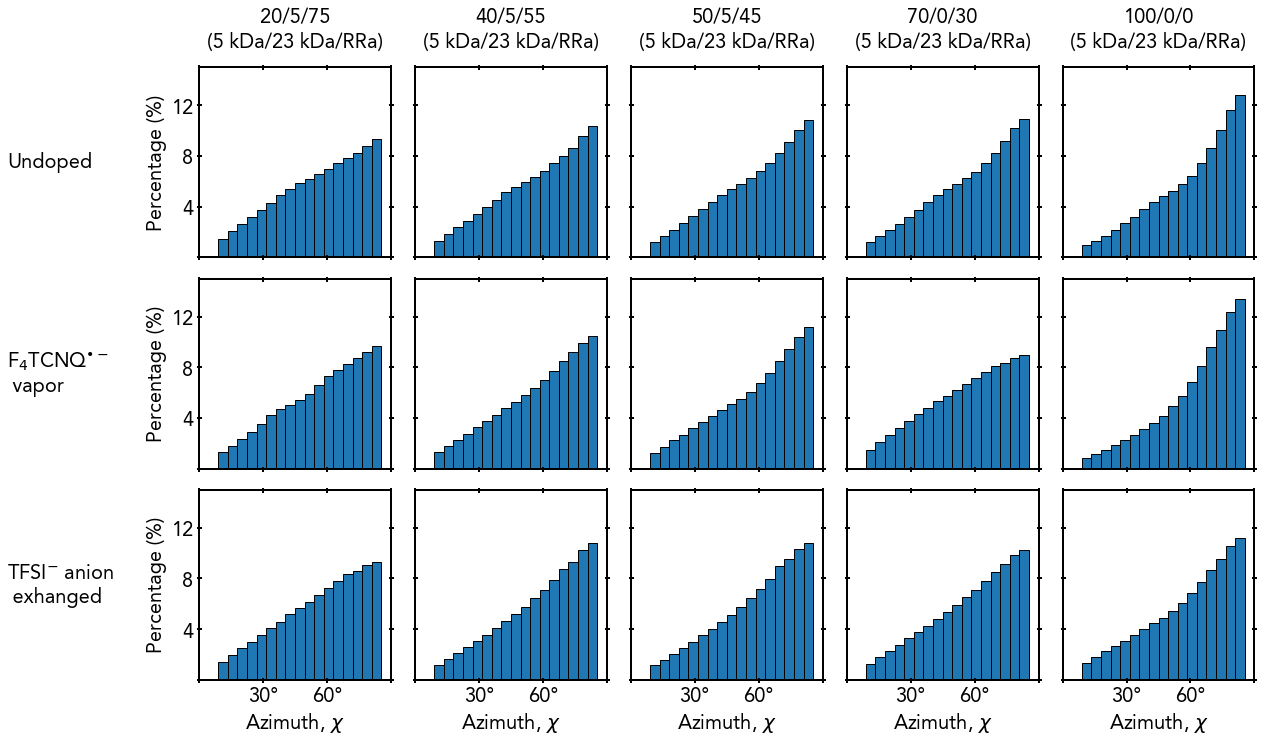

In [19]:
current_incidence_angle = 0.05

current_samples = ['EPAN', 'EPAV', 'EPAA', 'EPBN', 'EPBV', 'EPBA', 'EPCN', 'EPCV', 'EPCA', 'EPDN', 'EPDV', 'EPDA', 'EPEN', 'EPEV', 'EPEA']

dicts, scales = filter_data(data, current_samples, current_incidence_angle, 'orientation_dists')

[fig, axes] = plot_orientation_hists_grid(dicts, current_samples)

fig.savefig('orientation_hists_grid_0p05.tiff', bbox_inches = 'tight', pad_inches = 0.2, dpi = 300, transparent = False)


current_incidence_angle = 0.1

current_samples = ['EPAN', 'EPAV', 'EPAA', 'EPBN', 'EPBV', 'EPBA', 'EPCN', 'EPCV', 'EPCA', 'EPDN', 'EPDV', 'EPDA', 'EPEN', 'EPEV', 'EPEA']

dicts, scales = filter_data(data, current_samples, current_incidence_angle, 'orientation_dists')

[fig, axes] = plot_orientation_hists_grid(dicts, current_samples)

fig.savefig('orientation_hists_grid_0p1.tiff', bbox_inches = 'tight', pad_inches = 0.2, dpi = 300, transparent = False)


current_incidence_angle = 0.13

current_samples = ['EPAN', 'EPAV', 'EPAA', 'EPBN', 'EPBV', 'EPBA', 'EPCN', 'EPCV', 'EPCA', 'EPDN', 'EPDV', 'EPDA', 'EPEN', 'EPEV', 'EPEA']

dicts, scales = filter_data(data, current_samples, current_incidence_angle, 'orientation_dists')

[fig, axes] = plot_orientation_hists_grid(dicts, current_samples)

fig.savefig('orientation_hists_grid_0p13.tiff', bbox_inches = 'tight', pad_inches = 0.2, dpi = 300, transparent = False)

C:\Users\Phong\AppData\Local\Temp\ipykernel_28788\2487829046.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticklabels_with_degree)


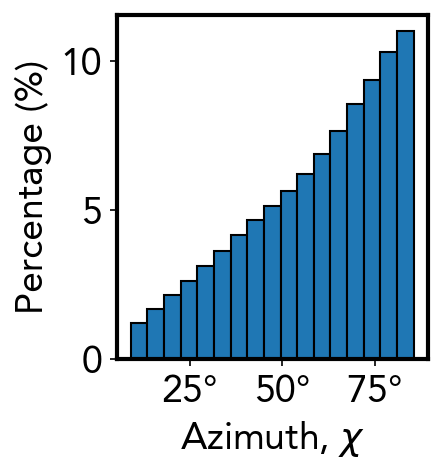

In [30]:
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

current_incidence_angle = 0.1

current_samples = ['EPAN', 'EPAV', 'EPAA', 'EPBN', 'EPBV', 'EPBA', 'EPCN', 'EPCV', 'EPCA', 'EPDN', 'EPDV', 'EPDA', 'EPEN', 'EPEV', 'EPEA']

dicts, scales = filter_data(data, current_samples, current_incidence_angle, 'orientation_dists')

sum_data = None
count = 0
chi_common = np.linspace(0, 90, num=1000)  # Common set of chi values for interpolation

for key, data in dicts.items():
    # Interpolate data onto the common set of chi values
    data_interp = data.interp(chi=chi_common)

    if sum_data is None:
        # Create a new DataArray filled with zeros having the same shape as the interpolated data
        sum_data = xr.DataArray(
            np.zeros(data_interp.shape),
            coords=data_interp.coords,
            dims=data_interp.dims
        )

    # Add the interpolated data to sum_data
    sum_data += data_interp
    count += 1

mean_orientation_dist = sum_data / count

# Normalize the data so it sums to 1
normalized_mean_chi = mean_orientation_dist / mean_orientation_dist.sum()

# Convert to percentage
percentage_mean_chi = normalized_mean_chi * 100

# Create a histogram plot
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=150)

ax.hist(percentage_mean_chi['chi'], weights=percentage_mean_chi, bins=20, edgecolor='black')

ax.set_xlabel('Azimuth, $\it{χ}$')
ax.set_ylabel('Percentage (%)')

# Get current x-ticks
x_ticks = ax.get_xticks()

# Modify x-tick labels to include degree symbol
x_ticklabels_with_degree = [f"{int(tick)}°" for tick in x_ticks]
ax.set_xticklabels(x_ticklabels_with_degree)

plt.tight_layout()
plt.show()

C:\Users\Phong\AppData\Local\Temp\ipykernel_28788\871707631.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticklabels_with_degree)


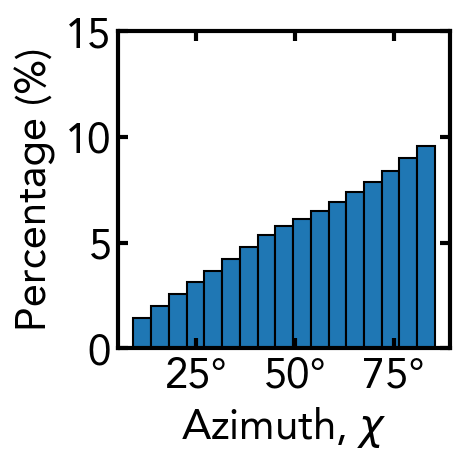

In [42]:
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2

# Create a histogram plot
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=150)

ax.hist(dicts['EPAN']['chi'].values, weights=dicts['EPAN'].values, bins=20, edgecolor='black')

x_ticks = generate_ticks(0, 90, num_ticks = 4, rounding_order = 1)
y_ticks = generate_ticks(0, 16, num_ticks = 5, rounding_order = 1)

ax.set_xlabel('Azimuth, $\it{χ}$')
ax.set_ylabel('Percentage (%)')

ax.set_ylim([0, 15])

# Get current x-ticks
x_ticks = ax.get_xticks()

# Modify x-tick labels to include degree symbol
x_ticklabels_with_degree = [f"{int(tick)}°" for tick in x_ticks]
ax.set_xticklabels(x_ticklabels_with_degree)
                   
ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

plt.tight_layout()
plt.show()

fig.savefig('least_oriented.tiff', bbox_inches = 'tight', pad_inches = 0.2, dpi = 300, transparent = False)

C:\Users\Phong\AppData\Local\Temp\ipykernel_28788\783107723.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticklabels_with_degree)


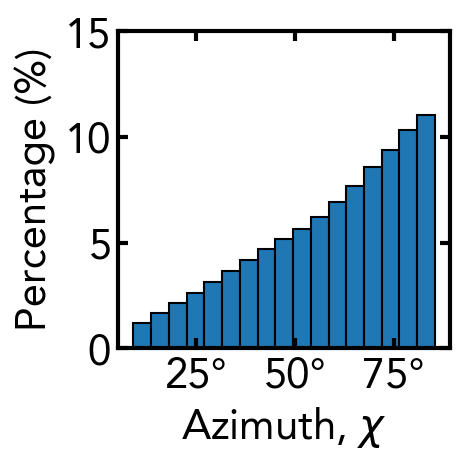

In [44]:
def export_to_csv(chi_values, percentages, filename='avg_0p1_theta_distribution.csv'):
    # Convert to numpy arrays
    chi_values = np.array(chi_values)
    percentages = np.array(percentages)

#     # Identify where the NaN values are
#     nan_indices = np.isnan(percentages)

#     # Interpolate missing percentages
#     valid_indices = ~nan_indices
#     interpolated_percentages = np.interp(chi_values, chi_values[valid_indices], percentages[valid_indices])

#     # Replace NaNs with interpolated values
#     percentages[nan_indices] = interpolated_percentages[nan_indices]

#     # Mirrored values (180 - original angles)
#     mirrored_chi_values = 180 - chi_values[::-1]
#     mirrored_percentages = percentages[::-1]

#     # Concatenating original and mirrored values
#     full_chi_values = np.concatenate((chi_values, mirrored_chi_values))
#     full_percentages = np.concatenate((percentages, mirrored_percentages))

#     # Create DataFrame and export to CSV
#     df = pd.DataFrame({
#         'chi': full_chi_values,
#         'percentage': full_percentages
#     })
    
        # Create DataFrame and export to CSV
    df = pd.DataFrame({
        'chi': chi_values,
        'percentage': percentages
    })
    
    df.to_csv(filename, index=False)

#     # Plot original, mirrored and combined distributions
#     fig, ax = plt.subplots(1, 3, figsize=(18, 6))

#     ax[0].bar(chi_values, percentages, edgecolor='black')
#     ax[0].set_title('Original Distribution')
#     ax[0].set_xlabel('Azimuth, $\\it{χ}$')
#     ax[0].set_ylabel('Percentage (%)')

#     ax[1].bar(mirrored_chi_values, mirrored_percentages, edgecolor='black')
#     ax[1].set_title('Mirrored Distribution')
#     ax[1].set_xlabel('Azimuth, $\\it{χ}$')
#     ax[1].set_ylabel('Percentage (%)')

#     ax[2].bar(full_chi_values, full_percentages, edgecolor='black')
#     ax[2].set_title('Combined Distribution')
#     ax[2].set_xlabel('Azimuth, $\\it{χ}$')
#     ax[2].set_ylabel('Percentage (%)')

#     plt.tight_layout()
#     plt.show()
    return chi_values, percentages

chi_values, percentages = export_to_csv(percentage_mean_chi['chi'].values, percentage_mean_chi.values)
    
# Create a histogram plot
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=150)

ax.hist(chi_values, weights=percentages, bins=20, edgecolor='black')

ax.set_xlabel('Azimuth, $\it{χ}$')
ax.set_ylabel('Percentage (%)')
ax.set_ylim([0, 15])

# Get current x-ticks
x_ticks = ax.get_xticks()

# Modify x-tick labels to include degree symbol
x_ticklabels_with_degree = [f"{int(tick)}°" for tick in x_ticks]
ax.set_xticklabels(x_ticklabels_with_degree)

ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in', right='on')

plt.tight_layout()
plt.show()
    
fig.savefig('average_orientation.tiff', bbox_inches = 'tight', pad_inches = 0.2, dpi = 300, transparent = False)

C:\Users\Phong\AppData\Local\Temp\ipykernel_28788\733665090.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(x_ticklabels_with_degree)
C:\Users\Phong\AppData\Local\Temp\ipykernel_28788\733665090.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(x_ticklabels_with_degree)


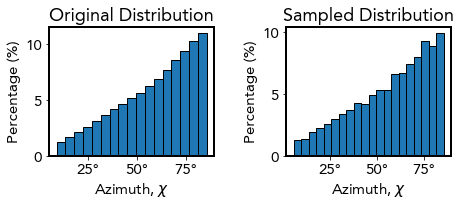

In [23]:
def sample_from_distribution(chi_values, weights):
    # Filter out NaN values from both chi_values and weights
    not_nan_indices = ~np.isnan(weights)
    chi_values = chi_values[not_nan_indices]
    weights = weights[not_nan_indices]
    
    # Normalize the weights
    normalized_weights = weights / np.sum(weights)
    
    # Sample a single data point from the distribution
    sample = np.random.choice(chi_values, 1, p=normalized_weights)
    return sample[0]

# Read the CSV file into a DataFrame
csv_file = 'avg_0p1_theta_distribution.csv'  # Replace with your actual file name
percentage_mean_chi = pd.read_csv(csv_file)

# Collect a large number of single samples in a loop
num_samples = 10000
samples = []
for _ in range(num_samples):
    sample = sample_from_distribution(percentage_mean_chi['chi'].values, percentage_mean_chi['percentage'].values)
    samples.append(sample)

# Convert the list of samples into a NumPy array
samples = np.array(samples)

# Plot original and sampled distributions
fig, ax = plt.subplots(1, 2, figsize=(3.5*2, 3.5))

# Plot original distribution
ax[0].hist(percentage_mean_chi['chi'], weights=percentage_mean_chi['percentage'], bins=20, edgecolor='black')
ax[0].set_xlabel('Azimuth, $\\it{χ}$')
ax[0].set_ylabel('Percentage (%)')
ax[0].set_title('Original Distribution')

# Get current x-ticks
x_ticks = ax[0].get_xticks()

# Modify x-tick labels to include degree symbol
x_ticklabels_with_degree = [f"{int(tick)}°" for tick in x_ticks]
ax[0].set_xticklabels(x_ticklabels_with_degree)

# Plot sampled distribution
counts, bin_edges = np.histogram(samples, bins=20)
normalized_counts = counts / num_samples * 100  # Normalize to percentage

ax[1].bar(bin_edges[:-1], normalized_counts, width=np.diff(bin_edges)[0], edgecolor='black')
ax[1].set_xlabel('Azimuth, $\\it{χ}$')
ax[1].set_ylabel('Percentage (%)')
ax[1].set_title('Sampled Distribution')

# Get current x-ticks
x_ticks = ax[1].get_xticks()

# Modify x-tick labels to include degree symbol
x_ticklabels_with_degree = [f"{int(tick)}°" for tick in x_ticks]
ax[1].set_xticklabels(x_ticklabels_with_degree)

plt.tight_layout(pad = 2)
plt.show()